In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.75 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 10000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

100000000.0


In [7]:
np.round(Eb, 4)

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.    ])

In [8]:
Eb

array([9.99999999e-05, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

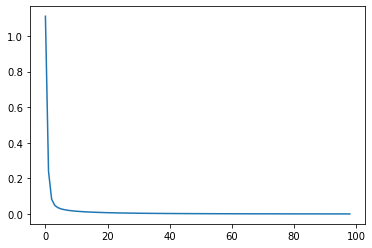

In [9]:
plt.plot(S)

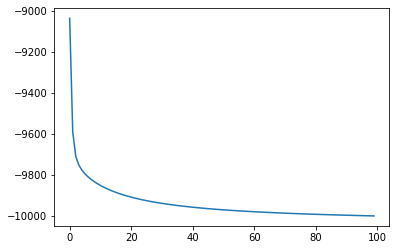

In [10]:
plt.plot(eta)

In [11]:
S[-1]

0.0006998551886099449

In [12]:
eta

array([-9035.23950214, -9590.53202642, -9710.21013926, -9752.00100474,
       -9776.49033606, -9794.50508995, -9809.09522517, -9821.50022835,
       -9832.34754195, -9842.00359888, -9850.70491169, -9858.61572754,
       -9865.8565619 , -9872.5196478 , -9878.67791906, -9884.39054768,
       -9889.70652831, -9894.66709713, -9899.30742392, -9903.65783293,
       -9907.74470813, -9911.59118043, -9915.21766024, -9918.64225785,
       -9921.88112046, -9924.9487061 , -9927.85800916, -9930.62074789,
       -9933.24752187, -9935.74794529, -9938.13076067, -9940.40393641,
       -9942.57475105, -9944.64986644, -9946.6353915 , -9948.53693807,
       -9950.35967002, -9952.10834658, -9953.78736068, -9955.40077301,
       -9956.95234235, -9958.44555255, -9959.88363683, -9961.26959941,
       -9962.60623507, -9963.89614665, -9965.14176095, -9966.34534301,
       -9967.5090091 , -9968.63473841, -9969.72438381, -9970.77968147,
       -9971.80225974, -9972.79364722, -9973.75528007, -9974.68850881,
      

In [13]:
eta_adj = eta - eta[-1]

In [14]:
eta_adj

array([9.64160499e+02, 4.08867975e+02, 2.89189862e+02, 2.47398997e+02,
       2.22909666e+02, 2.04894912e+02, 1.90304776e+02, 1.77899773e+02,
       1.67052460e+02, 1.57396403e+02, 1.48695090e+02, 1.40784274e+02,
       1.33543440e+02, 1.26880354e+02, 1.20722083e+02, 1.15009454e+02,
       1.09693473e+02, 1.04732904e+02, 1.00092578e+02, 9.57421686e+01,
       9.16552934e+01, 8.78088212e+01, 8.41823413e+01, 8.07577437e+01,
       7.75188811e+01, 7.44512955e+01, 7.15419924e+01, 6.87792537e+01,
       6.61524797e+01, 6.36520563e+01, 6.12692409e+01, 5.89960652e+01,
       5.68252505e+01, 5.47501351e+01, 5.27646101e+01, 5.08630635e+01,
       4.90403316e+01, 4.72916550e+01, 4.56126409e+01, 4.39992286e+01,
       4.24476592e+01, 4.09544490e+01, 3.95163647e+01, 3.81304022e+01,
       3.67937665e+01, 3.55038549e+01, 3.42582406e+01, 3.30546586e+01,
       3.18909925e+01, 3.07652632e+01, 2.96756178e+01, 2.86203201e+01,
       2.75977418e+01, 2.66063544e+01, 2.56447215e+01, 2.47114928e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_16.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_16.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_16.csv', S, delimiter = ',')

In [16]:
Eh

array([-1.27770249e-19, -1.64106382e-19, -1.33351600e-18, -2.63198685e-18,
       -2.70056778e-18, -2.74619214e-17,  6.22986786e-17, -4.18672210e-17,
       -3.59601614e-18, -5.33208250e-18, -5.33761323e-18, -5.45976764e-18,
       -4.93991587e-18, -5.49895687e-18, -2.23821689e-16,  4.91191407e-16,
       -2.69718950e-16,  1.70680944e-18,  1.68794503e-18,  5.40380279e-18,
       -5.87043422e-16,  1.93087317e-15, -2.10874608e-15,  7.69710696e-16,
        8.68077157e-16, -1.82251409e-15,  1.44650480e-15, -2.63886423e-15,
        3.87702682e-15, -2.60116680e-16, -3.06382253e-15,  1.59641674e-15,
       -8.87088709e-18, -7.40651742e-18,  2.34303547e-15, -4.80544166e-15,
        6.68597557e-16,  3.98306181e-15, -1.36570937e-15, -2.04806675e-15,
        2.19421745e-15, -4.81007189e-16, -3.30531741e-15,  5.25121261e-15,
       -3.60411294e-15,  1.65489869e-15,  1.05234683e-15, -1.20903952e-15,
       -8.84765513e-15,  1.47407714e-14, -6.43620569e-15, -2.49676806e-16,
        4.33089045e-15, -